In [1]:
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 100

In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [4]:
def process_dataframe(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_cabin(df)
    df = process_fare(df)
    df = process_titles(df)
    cols = ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"]
    for each in cols:
        df = create_dummies(df, each)
    return df

In [5]:
train = process_dataframe(train)
holdout = process_dataframe(holdout)

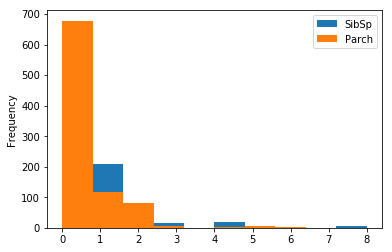

In [6]:
explore_cols = ['SibSp', 'Parch', 'Survived']
explore = train[explore_cols].copy()
explore.drop('Survived', axis=1).plot.hist()

       Survived
SibSp          
0      0.345395
1      0.535885
2      0.464286
3      0.250000
4      0.166667
5      0.000000
8      0.000000


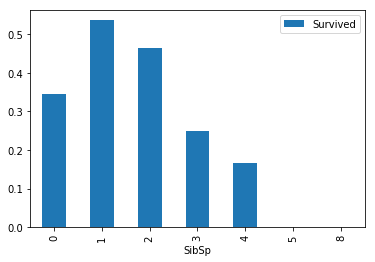

In [7]:
pivot = pd.pivot_table(explore, values='Survived', index=['SibSp'])
print(pivot)
pivot.plot.bar()

       Survived
Parch          
0      0.343658
1      0.550847
2      0.500000
3      0.600000
4      0.000000
5      0.200000
6      0.000000


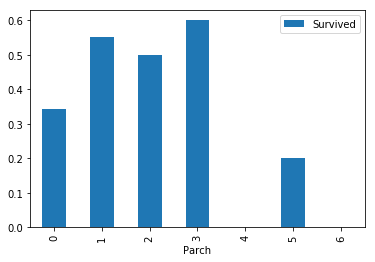

In [8]:
pivot = pd.pivot_table(explore, values='Survived', index=['Parch'])
print(pivot)
pivot.plot.bar()

          Survived
fam_size          
0         0.303538
1         0.552795
2         0.578431
3         0.724138
4         0.200000
5         0.136364
6         0.333333
7         0.000000
10        0.000000


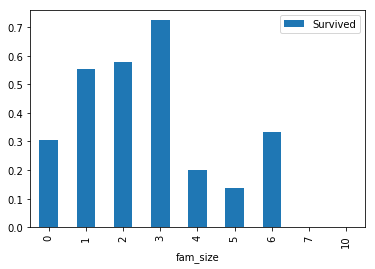

In [9]:
explore['fam_size'] = explore[['SibSp','Parch']].sum(axis=1)
pivot = pd.pivot_table(explore, values='Survived', index='fam_size')
print(pivot)
pivot.plot.bar()

Family size of 1-3 is associated with high survival rates.  Those who are alone (fam_size = 0) or have >3 members of family onboard are less likely to survive.

In [10]:
def alone_col(df):
    fam_size = df[['SibSp','Parch']].sum(axis=1)
    df['isalone'] = (fam_size == 0).astype(int)
    return df

In [11]:
train = alone_col(train)
holdout = alone_col(holdout)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_categories,Cabin_type,Fare_categories,Title,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Fare_categories_0-12,Fare_categories_12-50,Fare_categories_50-100,Fare_categories_100+,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Young Adult,Unknown,0-12,Mr,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult,C,50-100,Mrs,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Young Adult,Unknown,0-12,Miss,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Young Adult,C,50-100,Mrs,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Young Adult,Unknown,0-12,Mr,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1


In [12]:
def select_features(df):
    df = df.select_dtypes(include=[np.number])
    df = df.dropna(axis=1)
    all_X = df.drop(['Survived','PassengerId'],axis=1)
    all_y = df['Survived']
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf, cv=10)
    selector = selector.fit(all_X, all_y)
    best_cols = all_X.columns[selector.support_]
    print(best_cols)
    return best_cols

In [13]:
best_cols = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')


In [16]:
def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    
    models = [
        {
            'name': 'Logistic Regression',
            'model': LogisticRegression(),
            'hyper_parameters': {
                "solver": ["newton-cg", "lbfgs", "liblinear"]
            }
        },
        {
            'name': "K Nearest Neighbors",
            'model': KNeighborsClassifier(),
            'hyper_parameters': {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
        },
        {
            "name": "Random Forest",
            "model": RandomForestClassifier(random_state=1),
            'hyper_parameters': {
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
            }
        }
        
    ] 
    
    for model in models:
        print(model['name'],'\n','--------------')
        grid = GridSearchCV(model['model'], model['hyper_parameters'], cv=10)
        grid = grid.fit(all_X, all_y)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_model'] = grid.best_estimator_
        print("Best score: {}".format(model['best_score']))
        print("Best params: {}".format(model['best_params']))
        print()
        
    return models

In [17]:
models = select_model(train, best_cols)

Logistic Regression 
 --------------
Best score: 0.8204264870931538
Best params: {'solver': 'liblinear'}

K Nearest Neighbors 
 --------------
Best score: 0.7755331088664422
Best params: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

Random Forest 
 --------------
Best score: 0.8294051627384961
Best params: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 4}



In [18]:
def save_submission_file(model, holdout_df, features, filename = None):
    if filename == None:
        filename = 'submission.csv'
    holdout_predictions = model.predict(holdout_df[features])
    submission = pd.DataFrame({"PassengerId": holdout['PassengerId'], "Survived": holdout_predictions})
    submission.to_csv(filename, index=False)

In [19]:
save_submission_file(models[2]['best_model'], holdout, best_cols, filename='rf_submission.csv')

In [20]:
save_submission_file(models[0]['best_model'], holdout, best_cols, filename='lr_submission.csv')

In [21]:
save_submission_file(models[1]['best_model'], holdout, best_cols, filename='knn_submission.csv')